In [33]:
import torch
import seaborn as sns
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wayho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070 Laptop GPU'

In [35]:
tweet_data = pd.read_csv(
    'data/input/training.1600000.processed.noemoticon.csv',
    encoding = 'latin',
    header=None
    )
tweet_data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [36]:
tweet_data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
tweet_data[[
    'weekday',
    'month',
    'day',
    'time',
    'timezone',
    'year'
    ]] = tweet_data['date'].str.split(' ', n=5, expand=True)
tweet_data = tweet_data[['weekday', 'month', 'day', 'year',
                         'time', 'text', 'sentiment']]
tweet_data.sentiment = tweet_data.sentiment.apply(
    lambda x: 'Pos' if x == 4 else 'Neg')
tweet_data.head()

,weekday,month,day,year,time,text,sentiment
0,Mon,Apr,06,2009,22:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Neg
1,Mon,Apr,06,2009,22:19:49,is upset that he can't update his Facebook by ...,Neg
2,Mon,Apr,06,2009,22:19:53,@Kenichan I dived many times for the ball. Man...,Neg
3,Mon,Apr,06,2009,22:19:57,my whole body feels itchy and like its on fire,Neg
4,Mon,Apr,06,2009,22:19:57,"@nationwideclass no, it's not behaving at all....",Neg


<Axes: xlabel='weekday', ylabel='count'>

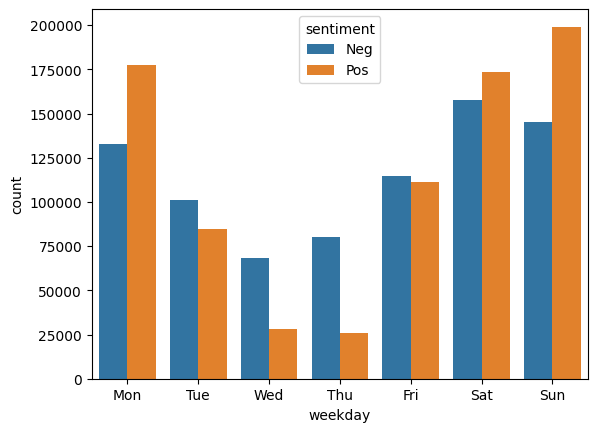

In [37]:
val_count = tweet_data.groupby('weekday')['sentiment'].value_counts()
val_count = val_count.reset_index(name='count')
sorted_weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
val_count['weekday'] = pd.Categorical(val_count['weekday'], sorted_weekdays)
sns.barplot(
    x='weekday',
    y='count',
    hue='sentiment',
    data=val_count
    )

<Axes: xlabel='sentiment'>

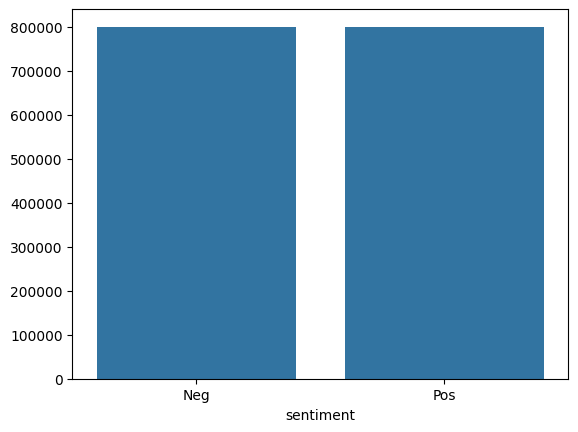

In [38]:
val_count = tweet_data['sentiment'].value_counts()
sns.barplot(
    x=val_count.index,
    y=val_count.values,
    )